In [ ]:
! pip install datasets
! pip install accelerate
! pip install einops

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms.functional as TF
from torch.optim import AdamW,lr_scheduler
from torchvision import transforms
from datasets import load_dataset,load_from_disk
from tqdm.auto import tqdm
from accelerate import Accelerator
from PIL import Image,ImageDraw
from einops import rearrange

ModuleNotFoundError: No module named 'datasets'

In [ ]:
# hyperparameters
num_bbox = 100
seq_length = 256
resize_size = (256,256)
patch_size = 16
num_patch_row, num_patch_col = resize_size[0]//patch_size, resize_size[1]//patch_size
threshold = 0.50
iou_threshold = 0.8
lambda_label = 100
lambda_bbox = 1
transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.ToTensor()
])

emb_size = 768
n_head = 12
num_layers = 6

# training args
batch_size = 64
learning_rate = 1e-4
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
accelerator = Accelerator()
device = accelerator.device
num_epoch = 10

PATH = r'/content/drive/MyDrive/2024Spring/640ComputerVision/model_checkpoint.pth'

# Useful function

In [ ]:
def draw_bbox(image, bounding_boxes):
  draw = ImageDraw.Draw(image)
  for bbox in bounding_boxes:
    x,y,w,h = bbox
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
  return image

In [ ]:
def IOU(bbox1,bbox2):
  x1, y1, w1, h1 = bbox1
  x2, y2, w2, h2 = bbox2
  x_left = max(x1, x2)
  y_top = max(y1, y2)
  x_right = min(x1 + w1, x2 + w2)
  y_bottom = min(y1 + h1, y2 + h2)
  intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)
  area1 = w1 * h1
  area2 = w2 * h2
  iou = intersection_area / (area1 + area2 - intersection_area)
  return iou

In [ ]:
def non_max_supression(labels_pred,bboxes_pred,iou_threshold):
  labels_pred,bboxes_pred = labels_pred.squeeze(),bboxes_pred.squeeze()
  labels_pred = nn.functional.sigmoid(labels_pred)
  mask = labels_pred > threshold
  valid_labels = labels_pred[mask].unsqueeze(1)
  valid_bboxes= bboxes_pred[mask]
  sorted_indices = torch.argsort(valid_labels[:,0],descending=True)
  valid_labels = valid_labels[sorted_indices]
  valid_bboxes = valid_bboxes[sorted_indices]

  result_bbox = []
  for current_bbox in valid_bboxes:
    flag = True
    for bbox in result_bbox:
      iou = IOU(bbox,current_bbox)
      if iou > iou_threshold:
        flag = False
        break
    if flag:
      result_bbox.append(current_bbox.cpu().detach().numpy())

  return np.array(result_bbox)

In [ ]:
def generate(model, image):
  original_size = image.size
  width_ratio,height_ratio = original_size[0]/resize_size[0],original_size[1]/resize_size[1]
  image_tensor = transform(image).unsqueeze(0).to(device)
  labels_pred, bboxes_pred = model(image_tensor)
  result_bbox = non_max_supression(labels_pred,bboxes_pred,iou_threshold)
  if result_bbox.shape[0] == 0:
    return image
  result_bbox[:,[0,2]] *= width_ratio
  result_bbox[:,[1,3]] *= height_ratio
  image = draw_bbox(image,result_bbox)
  return image

# Define model

In [7]:
import torch
import torch.nn as nn


class Embedding(nn.Module):
  def __init__(self,seq_length, emb_size, patch_size, in_channels=3):
    super().__init__()
    self.pos_embedding = nn.Parameter(torch.randn(1, num_patch_row*num_patch_col, emb_size))
    self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
  def forward(self, x):
    # x.shape = [B,3,256,256]
    patch_emb = self.proj(x) # [B,768,patch_size,patch_size]
    patch_emb = rearrange(patch_emb, 'b e h w -> b (h w) e')
    embedding = patch_emb + self.pos_embedding # [B,1,256,768]
    return embedding
  
  
def test_Embedding():
  # Define input tensor
  B = 2
  in_channels = 3
  seq_length = 256
  emb_size = 768
  patch_size = 16
  num_patch_row = seq_length // patch_size
  num_patch_col = seq_length // patch_size
  x = torch.randn(B, in_channels, seq_length, seq_length)

  # Create Embedding instance
  embedding = Embedding(seq_length, emb_size, patch_size, in_channels)

  # Forward pass
  output = embedding(x)

  print("Test passed!")
  return output

In [6]:

# Run the test
test_Embedding()

NameError: name 'num_patch_row' is not defined

In [14]:
class Encoder(nn.Module):
  def __init__(self, n_head, num_layers, emb_size):
    super().__init__()
    encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=n_head, batch_first=True)
    self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
  def forward(self,x):
    logits = self.encoder(x)    # [B,T,C]
    return logits

In [18]:
def test_encoder_forward():
    # 定义输入参数
    n_head = 4
    num_layers = 3
    emb_size = 128
    batch_size = 10
    seq_length = 20

    # 初始化 Encoder
    encoder = Encoder(n_head=n_head, num_layers=num_layers, emb_size=emb_size)

    # 生成测试输入，尺寸为 [batch_size, seq_length, emb_size]
    test_input = torch.randn(batch_size, seq_length, emb_size)

    # 执行前向传播
    output = encoder(test_input)

    return output

In [19]:
test_encoder_forward()

tensor([[[ 1.4416e-01,  6.2535e-01, -1.0308e+00,  ..., -3.1385e-01,
          -3.1436e-01, -8.5180e-01],
         [ 3.8000e-01, -2.4369e-01, -1.1446e+00,  ...,  5.8446e-01,
          -3.6131e-02, -1.2781e+00],
         [ 9.7496e-01, -8.9833e-01,  3.6925e-01,  ..., -5.9384e-02,
          -7.2187e-02, -3.6599e-01],
         ...,
         [ 2.4687e+00,  5.6677e-01, -1.9181e+00,  ...,  6.2592e-01,
          -9.1011e-01, -1.8959e+00],
         [-9.2067e-01, -2.1685e+00,  5.4080e-01,  ..., -3.8693e-01,
          -1.8457e-01,  3.9257e-03],
         [ 6.5303e-01, -2.5144e-01, -1.5826e+00,  ..., -4.0956e-01,
          -2.2088e+00, -4.2358e-01]],

        [[-8.6329e-01,  1.4282e+00,  6.6758e-01,  ...,  2.0622e-01,
          -2.2681e-01,  4.0270e-02],
         [ 4.2388e-01, -1.2339e+00, -7.9042e-01,  ..., -1.4622e+00,
          -1.8840e-01, -1.3408e+00],
         [-1.3948e-01, -2.0694e+00, -5.1536e-01,  ..., -1.9156e-01,
           9.7214e-02,  1.5499e+00],
         ...,
         [-3.1697e-01, -1

def test_encoder_forward(self):
    # 定义输入参数
    n_head = 4
    num_layers = 3
    emb_size = 128
    batch_size = 10
    seq_length = 20

    # 初始化 Encoder
    encoder = Encoder(n_head=n_head, num_layers=num_layers, emb_size=emb_size)

    # 生成测试输入，尺寸为 [batch_size, seq_length, emb_size]
    test_input = torch.randn(batch_size, seq_length, emb_size)

    # 执行前向传播
    output = encoder(test_input)

    return output

In [15]:
def test_encoder_output_shape():
  # Parameters
  n_head = 8
  num_layers = 3
  batch_size = 10
  seq_length = 20
  embedding_size = 64


  # Model
  encoder = Encoder(n_head=n_head, num_layers=num_layers, emb_size=embedding_size)

  # Test input: batch of sequences, each with specified sequence length and embedding size
  test_input = torch.randn(batch_size, seq_length, embedding_size)

  # Forward pass
  output = encoder(test_input)

  return output
  # assertEqual(output.shape, expected_shape, "Output shape is incorrect")

In [16]:
test_encoder_output_shape()

tensor([[[ 0.5944,  0.9389, -1.0853,  ..., -1.7822, -0.9886, -0.6980],
         [-0.2138, -0.8232,  0.6288,  ...,  0.4515, -1.0900, -0.6238],
         [ 0.8323, -0.4742, -0.4579,  ...,  0.8029, -1.1747, -1.2299],
         ...,
         [ 0.8131, -0.3664,  0.4230,  ...,  0.0647, -1.5470, -1.0527],
         [ 2.0845, -0.7665, -0.2256,  ...,  0.3026, -1.2457, -0.7961],
         [ 0.2534,  0.9896, -1.4691,  ..., -0.4696,  2.2793, -0.1666]],

        [[ 1.4697, -1.9227, -1.6821,  ...,  0.7742, -0.7774,  1.4903],
         [ 1.3158,  0.7654, -0.4270,  ..., -2.2641,  0.3735, -0.5702],
         [-0.0366, -1.2319,  1.0330,  ..., -1.4244, -1.1469,  0.0360],
         ...,
         [ 1.5430, -0.9800, -0.4241,  ..., -0.5025,  0.2951, -1.5051],
         [ 0.4787,  0.2237, -0.2078,  ..., -0.4568, -0.4215, -0.8356],
         [ 0.5203, -1.6548,  0.7614,  ...,  0.1819,  1.0403, -1.0962]],

        [[ 1.1041, -2.1381,  1.1904,  ..., -1.9616, -0.3772, -1.0440],
         [ 1.9101,  0.2901, -0.5661,  ..., -1

In [ ]:
class OutHead(nn.Module):
  def __init__(self,emb_size,seq_length,num_bbox):
    super().__init__()
    self.flatten = nn.Flatten(start_dim=1)
    self.label_head = nn.Linear(emb_size*seq_length, num_bbox)
    self.bbox_head = nn.Linear(emb_size*seq_length, 4*num_bbox)
    self.relu = nn.ReLU()
    self.num_bbox = num_bbox
  def forward(self,x):
    x = self.relu(x)          # [B,T,C]
    x = self.flatten(x)       # [B,T*C]
    # x = torch.max(x,dim=1)[0] # [B,C]
    labels = self.label_head(x)  # [B,num_bbox]
    bboxes = self.bbox_head(x)   # [B,4*num_bbox]
    bboxes = bboxes.reshape(-1,num_bbox,4)
    return labels,bboxes

In [ ]:
class ViT(nn.Module):
  def __init__(self,seq_length,emb_size,n_head,num_layers,num_bbox,patch_size):
    super().__init__()
    self.embedding = Embedding(seq_length, emb_size, patch_size)
    self.encoder = Encoder(n_head,num_layers,emb_size)
    self.out = OutHead(emb_size,seq_length,num_bbox)
    for p in self.encoder.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)
  def forward(self,x):
    x = self.embedding(x)
    x = self.encoder(x)
    print('logits')
    print(x[0,:5])
    labels, bboxes = self.out(x)
    return labels, bboxes

In [ ]:
class Loss_fn(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,labels_pred,bbox_pred,labels_target,bbox_target,valid_lengths):
    labels_pred = torch.sigmoid(labels_pred)
    label_loss = nn.functional.binary_cross_entropy(labels_pred, labels_target, reduction='none')
    bbox_loss = nn.functional.mse_loss(bbox_pred, bbox_target, reduction='none').mean(dim=(2))

    mask = torch.arange(labels_pred.size(1)).unsqueeze(0).to(device) < valid_lengths.unsqueeze(1)
    masked_label_loss = label_loss # * mask
    masked_bbox_loss = bbox_loss * mask
    print(masked_label_loss[0,:5])
    print(masked_bbox_loss[0,:5])
    label_loss = torch.zeros_like(valid_lengths, dtype=torch.float32)
    bbox_loss = torch.zeros_like(valid_lengths, dtype=torch.float32)
    non_zero_lengths = valid_lengths > 0
    if torch.any(non_zero_lengths):
        label_loss[non_zero_lengths] = (masked_label_loss[non_zero_lengths] / valid_lengths.float()[non_zero_lengths].unsqueeze(1)).sum(dim=1)
        bbox_loss[non_zero_lengths] = (masked_bbox_loss[non_zero_lengths] / valid_lengths.float()[non_zero_lengths].unsqueeze(1)).sum(dim=1)

    loss = lambda_label * label_loss + lambda_bbox * bbox_loss
    print(lambda_label * label_loss,lambda_bbox * bbox_loss)
    loss = loss.mean()/batch_size
    return loss

# Load data

In [ ]:
# wider_face = load_dataset("NekoJojo/modified_wider_face")
# wider_face.save_to_disk('/content/drive/MyDrive/2024Spring/640ComputerVision/DATA')

In [ ]:
wider_face = load_from_disk('/content/drive/MyDrive/2024Spring/640ComputerVision/DATA')

Loading dataset from disk:   0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
class FaceData(Dataset):
  def __init__(self,data):
    super().__init__()
    self.data = data
    self.transform = transforms.Compose([
      transforms.Resize((256, 256)),
      transforms.ToTensor()
    ])
  def __getitem__(self, index):
    sample = self.data[index]
    image = sample['image']
    image = self.transform(image)
    labels = torch.tensor(sample['labels'],dtype=torch.float32)
    valid_length = torch.tensor(sample['valid_length'],dtype=torch.float32)
    original_size = torch.tensor(sample['original_size'],dtype=torch.float32)
    bbox = torch.tensor(sample['resized_bbox'],dtype=torch.float32)
    return {'image':image,'labels':labels,'valid_length':valid_length,'original_size':original_size,'bbox':bbox}
  def __len__(self):
    return len(self.data)

In [ ]:
wider_face_train = FaceData(wider_face['train'])
wider_face_val = FaceData(wider_face['val'])
train_dataloader = DataLoader(wider_face_train,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(wider_face_val,batch_size=batch_size)

In [ ]:
# # dataloader test
# for b in train_dataloader:
#   batch = b
#   break
# print(batch.keys())

# # model test
# print(batch['patches'].shape)
# test_input = batch['patches'].to(device)
# test_model = ViT(seq_length,emb_size,n_head,num_layers,num_bbox,patch_size).to(device)
# test_out_labels,test_out_bboxes = test_model(test_input)
# print(np.sum([p.numel() for p in test_model.parameters()]))
# print(test_out_labels.shape,test_out_bboxes.shape)

# # loss function test
# labels_target = batch['labels'].to(device)
# bbox_target = batch['bbox'].to(device)
# valid_lengths = batch['valid_length'].to(device)
# loss_fn_test = Loss_fn()
# loss_test = loss_fn_test(test_out_labels,test_out_bboxes,labels_target,bbox_target,valid_lengths)
# loss_test

In [ ]:
model = ViT(seq_length,emb_size,n_head,num_layers,num_bbox,patch_size).to(device)
optim = AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = lr_scheduler.CosineAnnealingLR(optim,T_max=num_epoch)
loss_fn = Loss_fn()

In [ ]:
try:
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optim.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
except:
    start_epoch = 0
optim,scheduler,train_dataloader = accelerator.prepare(optim,scheduler,train_dataloader)

In [ ]:
lossi = []
count = 0
for epoch in range(start_epoch,num_epoch):
  progress_bar = tqdm(train_dataloader)
  model.train()
  model = accelerator.prepare(model)
  for batch in train_dataloader:
    # labels_target = batch['labels'].to(device)
    # valid_lengths = batch['valid_length'].to(device)
    # bboxes_target = batch['bbox'].to(device)
    # patches = batch['patches'].to(device)
    labels_target = batch['labels']
    valid_lengths = batch['valid_length']
    bboxes_target = batch['bbox']
    image = batch['image']
    labels_pred,bboxes_pred = model(image)
    loss = loss_fn(labels_pred,bboxes_pred,labels_target,bboxes_target,valid_lengths)

    optim.zero_grad()
    # loss.backward()
    accelerator.backward(loss)
    optim.step()

    model.eval()
    with torch.no_grad():
      print('evaluation:')
      print('++++++++++++++++++++++++++++++++++')
      val_label_pred,val_bboxes_pred = model(image)
      print('**********************************')
    # if count % 1 == 0:  # Check at every epoch or adjust based on your preference
    #   check_gradients(epoch, model)

    progress_bar.update(1)
    count += 1
    lossi.append(loss.item())
    if count % 50 == 0:
        print('loss: ',loss.item())
  scheduler.step()
  model = accelerator.unwrap_model(model)
  torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, PATH)
  print('epoch: ',epoch,' loss: ',loss.item())

In [ ]:
model = accelerator.unwrap_model(model)
torch.save({
      'epoch': epoch+1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optim.state_dict(),
      'scheduler_state_dict': scheduler.state_dict(),
  }, PATH)

embedding
tensor([[[-0.0693, -0.3118, -0.0531,  ...,  0.0153,  0.3383,  1.5326],
         [ 0.3835,  0.4040,  0.2911,  ..., -1.4608,  0.7959, -0.6800],
         [-0.5436,  0.9973,  0.3809,  ...,  0.0628, -1.1647, -0.7871],
         ...,
         [-1.6524,  1.7260, -1.1528,  ...,  2.7858, -1.4784, -0.8390],
         [-0.4516,  0.5137, -0.0107,  ..., -0.6833,  0.6141,  1.5904],
         [-0.6630, -0.0873,  1.3757,  ..., -0.6363,  0.9264,  0.3865]]],
       device='cuda:0', grad_fn=<AddBackward0>)
logits
tensor([[[-0.0507, -0.2635,  1.3087,  ..., -0.0788, -0.5240, -0.6524],
         [-0.0507, -0.2635,  1.3087,  ..., -0.0788, -0.5240, -0.6524],
         [-0.0507, -0.2635,  1.3087,  ..., -0.0788, -0.5240, -0.6524],
         ...,
         [-0.0507, -0.2635,  1.3087,  ..., -0.0788, -0.5240, -0.6524],
         [-0.0507, -0.2635,  1.3087,  ..., -0.0788, -0.5240, -0.6524],
         [-0.0507, -0.2635,  1.3087,  ..., -0.0788, -0.5240, -0.6524]]],
       device='cuda:0', grad_fn=<NativeLayerNormBac

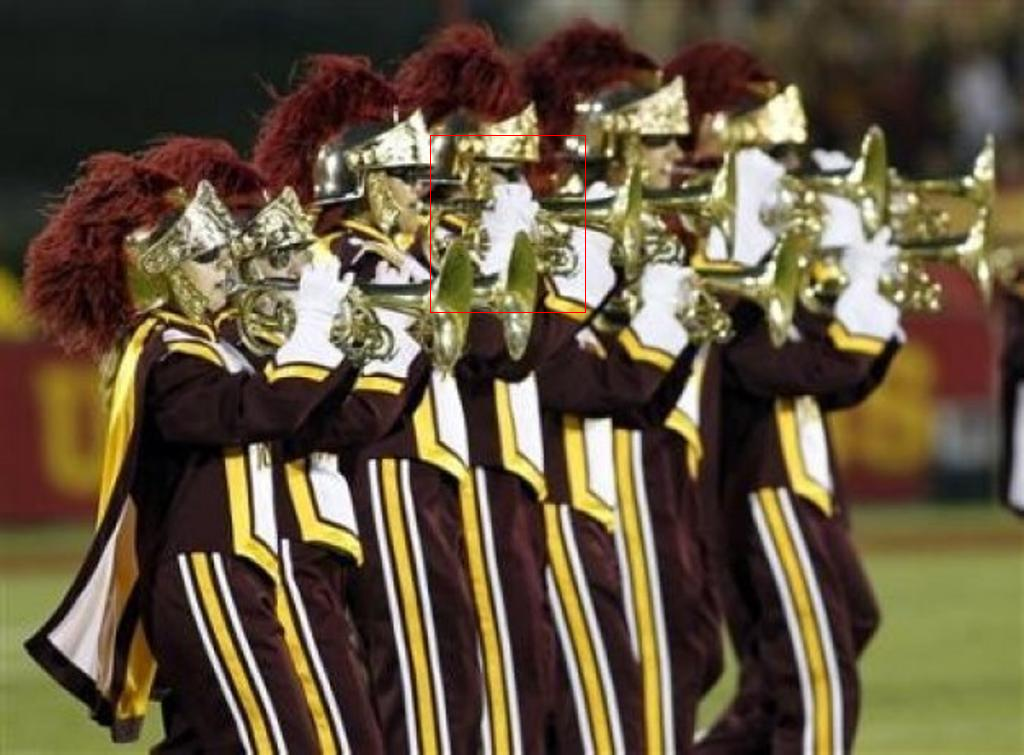

In [ ]:
model.eval()
image = wider_face['train'][10]['image']
processed_image = generate(model,image)
processed_image